In [1]:
import os
import math
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
# from torch.nn.modules.loss import _WeightedLoss
# from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
# from torch.utils.data.sampler import SubsetRandomSampler
# from torch.utils.data import TensorDataset, random_split
import torchvision
# from torchvision import datasets, transforms, models

In [2]:
paths = pd.Series({
    'train_dir': 'tests/00_test_img_input/train/',
    'train_images_dir_slow': 'tests/00_test_img_input/train/images/',
    'train_images_dir': 'tests/00_test_img_input/train/images/',
    'train_gt': 'tests/00_test_img_input/train/gt.csv',
})

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
from run import read_csv
train_gt = read_csv(paths.train_gt)

print(f'{len(train_gt)} samples, {len(set(train_gt.values()))} labels')

2500 samples, 50 labels


In [5]:
perm = np.random.RandomState(seed=42).permutation(2500)
train_gt_items = list(train_gt.items())

train_gt_t = {train_gt_items[i][0]: train_gt_items[i][1] for i in perm[:2000]}
train_gt_v = {train_gt_items[i][0]: train_gt_items[i][1] for i in perm[2000:]}

#### Preprocess

In [6]:
# def img_read(img_path):
#     """
#     returns (h, w, 3) 0..255 image
#     """
#     img = cv2.imread(img_path)[..., ::-1]
#     assert img is not None, 'file not found'
#     return img

In [7]:
IMG_SIZE = 500
LABEL_SIZE = 50

# def img_preprocess(img):
#     """
#     (h, w, 3) 0..255 numpy image -> (3, IMG_SIZE, IMG_SIZE) 0..1 torch image
#     """
#     height, width = img.shape[:2]
#     assert len(img.shape) == 3 and img.shape[2] == 3
#     assert width <= IMG_SIZE and height <= IMG_SIZE
    
#     top = (IMG_SIZE - height) // 2
#     bottom = IMG_SIZE - height - top
#     left = (IMG_SIZE - width) // 2
#     right = IMG_SIZE - width - left
    
#     prep_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT)
#     assert len(img.shape) == 3 and img.shape[2] == 3
#     assert prep_img.shape[0] == prep_img.shape[1] == IMG_SIZE
    
#     prep_img = prep_img / 255
    
#     prep_img = torch.from_numpy(prep_img.transpose(2, 0, 1)).to(torch.float)
#     assert prep_img.shape == (3, IMG_SIZE, IMG_SIZE)
    
#     return prep_img

def label_preprocess(label):
    """
    0,...,49 -> torch[..., 0, 1, 0, ...]
    """
    assert isinstance(label, int) and 0 <= label < LABEL_SIZE
    
    res_label = torch.zeros(LABEL_SIZE, dtype=torch.float)
    res_label[label] = 1
    
    return res_label

In [8]:
from PIL import Image

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

augmentation = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    
    torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.7),
    
    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def img_read(img_path):
    input_image = Image.open(img_path)
    input_image = input_image.convert(mode='RGB')
    return input_image

def img_preprocess(img, aug=False):
    prep_image = augmentation(img) if aug else preprocess(img)
    # assert prep_image.shape[0] == 3, f'lol shape {img_path} is {prep_image.shape}'
    return prep_image

def read_and_preprocess(img_path, aug=False):
    input_image = img_read(img_path)
    prep_image = img_preprocess(input_image, aug=aug)
    return prep_image

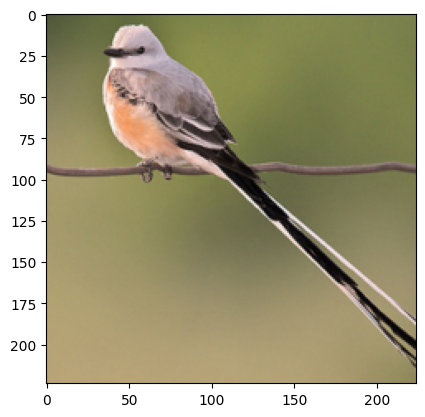

In [9]:
plt.imshow(read_and_preprocess(paths.train_images_dir + list(train_gt.keys())[904], True).numpy().transpose(1, 2, 0))

#### Example

In [10]:
# https://pytorch.org/hub/pytorch_vision_mobilenet_v2/

# from PIL import Image
# from torchvision import transforms

# filename = paths.train_images_dir + list(train_gt.keys())[1000]
# input_image = Image.open(filename)
# preprocess = torchvision.transforms.Compose([
#     torchvision.transforms.Resize(256),
#     torchvision.transforms.CenterCrop(224),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
# input_tensor = preprocess(input_image)
# input_batch = input_tensor.unsqueeze(0)


# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model.to('cuda')

# with torch.no_grad():
#     output = model(input_batch)

# probabilities = torch.nn.functional.softmax(output[0], dim=0)
# print(probabilities.argmax())


In [11]:
# plt.figure(figsize=(20, 10))

# for i, index in enumerate(np.random.randint(0, 2500, 5)):
#     img = img_read(paths.train_images_dir + list(train_gt.keys())[index])
    
    
#     prep_img = img_preprocess(torch.from_numpy(imgs[index].copy()))
    
#     plt.subplot(2, 5, 1 + i)
#     plt.imshow(img)
#     plt.subplot(2, 5, 1 + i + 5)
#     plt.imshow(prep_img)
#     print(prep_img.shape)
# plt.show()

#### Dataset

In [12]:
# class MyDataset(Dataset):
#     def __init__(self, train_gt, imgs_dir, aug=False):
#         self.imgs_dir = imgs_dir
#         self.aug = aug
        
#         self.items = []
#         for img_filename, label in tqdm(train_gt.items()):  
#             self.items.append((img_filename, label))
    
#     def __len__(self):
#         return len(self.items)
    
#     def __getitem__(self, index):
#         img_filename, label = self.items[index]
        
#         prep_img = read_and_preprocess(self.imgs_dir + img_filename, aug=self.aug)
#         prep_label = label_preprocess(label)
#         return prep_img, prep_label
    
class MyFastDataset(Dataset):
    def __init__(self, train_gt, imgs_dir, aug=False):
        self.imgs_dir = imgs_dir
        self.aug = aug
        
        self.items = []
        for img_filename, label in tqdm(train_gt.items()): 
            img_path = self.imgs_dir + img_filename
            
            input_image = img_read(img_path)
            # prep_img = read_and_preprocess(, aug=self.aug)
            prep_label = label_preprocess(label)
            
            self.items.append((input_image, prep_label))
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, index):
        input_image, prep_label = self.items[index]
        prep_image = img_preprocess(input_image, aug=self.aug)
        return prep_image, prep_label

In [13]:
train_dataset = MyFastDataset(train_gt_t, paths.train_images_dir, aug=True)
val_dataset = MyFastDataset(train_gt_v, paths.train_images_dir, aug=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [2000, 500])
# train_dataset.dataset.aug = True

In [15]:
# torch.manual_seed(torch.initial_seed())

#### Dataloader

In [16]:
BATCH_SIZE = 50

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#### Model

In [17]:
torch.hub.set_dir('cache/')
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in cache/pytorch_vision_v0.10.0
/home/zalevskiaa/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zalevskiaa/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# model

In [19]:
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=512),
)

In [20]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        torch.hub.set_dir('cache/')
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
        
        for param in self.model.parameters():
            param.requires_grad = False
            
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=2048, out_features=50),
        )
        
    def forward(self, x):
        return F.log_softmax(self.model(x), dim=1)

In [21]:
# class MyOldModel(torch.nn.Module):
#     def __init__(self):
#         super(MyModel, self).__init__()
        
#         torch.hub.set_dir('cache/')
#         self.mobilenet_model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
        
#         for param in self.mobilenet_model.parameters():
#             param.requires_grad = False
            
#         self.mobilenet_model.classifier[1] = nn.Linear(in_features=1280, out_features=50)
        
#     def forward(self, x):
#         return F.log_softmax(self.mobilenet_model(x), dim=1)

#### Train/Val

In [22]:
def count_correct(a, b):
    """
    a, b: (batch_size, labels_count)-sized tensors
    returns: (correct, total)
    """
    assert a.shape == b.shape
    batch_size = a.shape[0]
    am = a.argmax(dim=1)
    bm = b.argmax(dim=1)
    
    assert am.shape[0] == bm.shape[0] == batch_size
    correct = int((am == bm).sum())
    
    return correct, batch_size

In [23]:
def train(model, optimizer, dataloader, criterion):
    model.train()
    
    losses_tr = []
    correct, total = 0, 0
    
    for images, labels in tqdm(dataloader, leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        
        losses_tr.append(loss.item())
        c, t = count_correct(out, labels)
        correct += c
        total += t
        
    return model, optimizer, np.mean(losses_tr), correct, total

def val(model, dataloader, criterion):
    model.eval()
    
    losses_val = []
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            out = model(images)
            loss = criterion(out, labels)

            losses_val.append(loss.item())
            c, t = count_correct(out, labels)
            correct += c
            total += t
            
    return np.mean(losses_val), correct, total

#### Training loop

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
for i in range(20):
    print(f'{i} {float(scheduler.get_last_lr()[0]):.10f}')
    optimizer.step()
    scheduler.step()

0 0.0002000000
1 0.0001600000
2 0.0001280000
3 0.0001024000
4 0.0000819200
5 0.0000655360
6 0.0000524288
7 0.0000419430
8 0.0000335544
9 0.0000268435
10 0.0000214748
11 0.0000171799
12 0.0000137439
13 0.0000109951
14 0.0000087961
15 0.0000070369
16 0.0000056295
17 0.0000045036
18 0.0000036029
19 0.0000028823


In [25]:
def set_rg(model, rg_true, abort=False):
    if abort:
        return
    
    p_total = 0
    for i, e in enumerate(model.parameters()):
        e.requires_grad = False
        p_total += 1
        
    assert 0 <= rg_true <= p_total
    first_rgt_param = p_total - rg_true
    
    rgt = 0
    for i, e in enumerate(model.parameters()):
        if i >= first_rgt_param:
            e.requires_grad = True
            rgt += 1
    
    assert rgt == rg_true

In [26]:
model = MyModel().to(device)
losses_tr, losses_val = [], []
accs_tr, accs_val = [], []

Using cache found in cache/pytorch_vision_v0.10.0


In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 2
for epoch in tqdm(range(EPOCHS)):
    if True:
        if epoch == 5:
            set_rg(model, 6)
        elif epoch == 8:
            set_rg(model, 10)
        elif epoch == 10:
            set_rg(model, 20)
        elif epoch == 13:
            set_rg(model, 50)
        elif epoch == 15:
            set_rg(model, 161)
        
    model, optimizer, loss_tr, ct, tt = train(model, optimizer, train_dataloader, criterion)
    loss_val, cv, tv = val(model, val_dataloader, criterion)
    scheduler.step()
    
    assert tt == 2000 and tv == 500
    
    losses_tr.append(loss_tr)
    losses_val.append(loss_val)
    accs_tr.append(ct / tt)
    accs_val.append(cv / tv)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

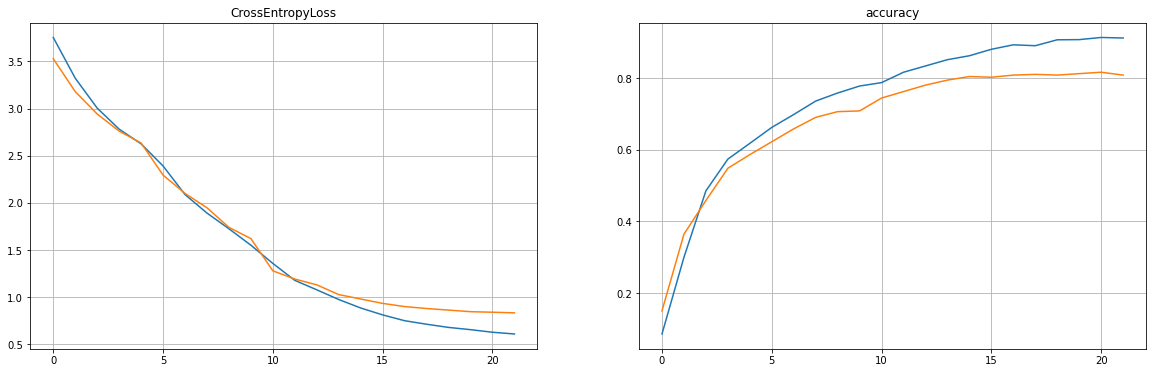

[0.907, 0.913, 0.9115]
[0.812, 0.816, 0.808]


In [34]:
plt.figure(figsize=(20,6))

plt.subplot(1, 2, 1)
plt.title('CrossEntropyLoss')
plt.grid()
plt.plot(losses_tr[:])
plt.plot(losses_val[:])

plt.subplot(1, 2, 2)
plt.title('accuracy')
plt.grid()
plt.plot(accs_tr[:])
plt.plot(accs_val[:])

plt.show()

print(accs_tr[-3:])
print(accs_val[-3:])

In [37]:
#torch.save(model.to(torch.device('cpu')).state_dict(), 'models/val_0.808_birds_model.ckpt')

#### Test

In [39]:
class MyTestDataset(Dataset):
    def __init__(self, imgs_dir):
        self.imgs_dir = imgs_dir
        filenames = os.listdir(imgs_dir)
        self.items = [filename for filename in filenames]
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, index):
        img_filename = self.items[index]
        prep_img = read_and_preprocess(self.imgs_dir + img_filename, aug=False)
        return img_filename, prep_img

In [64]:
def test(model, dataloader):
    model.eval()

    result_labels = {}

    with torch.no_grad():
        for img_filenames, images in tqdm(dataloader):
            images = images.to(device)

            out = model(images)

            labels = out.cpu().detach().numpy()
            for filename, label in zip(img_filenames, labels):
                am = label.argmax()
                result_labels[filename] = am
        # print(labels)
        # print(img_orig_shapes)
        # break

        # result_labels.extend(labels)

    return result_labels

In [65]:
test_dataset = MyTestDataset(paths.train_images_dir)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [66]:
res_labels = test(model, test_dataloader)

  0%|          | 0/50 [00:00<?, ?it/s]